# Creación de un modelo desde cero

## Librerías necesarias

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

## Variables globales del sistema

In [21]:
original_dir = pathlib.Path("DatasetOriginal/Image Data Base")
new_base_dir = pathlib.Path("TFGDataset")
content = os.listdir(original_dir)
BATCH_SIZE = 64
size_x = 256
size_y = 256

## Función para contar imágenes por categorías

In [16]:
def contando_categorias():
    counter_more200 = 0
    counter_less200 = 0
    categories = {}
    for category in content:
        counter = 0
        for path in pathlib.Path(original_dir / category).iterdir():   
            counter += 1
        if counter < 200:
            counter_less200 += 1
            categories.update({str(category):counter})
            
        else:
            counter_more200 += 1
    print("Hay "+ str(counter_more200) + " categorias con más de 200 ejemplos")
    print("Hay "+ str(counter_less200) + " categorias con menos de 200 ejemplos")
    return categories
        
categories = contando_categorias()

Hay 34 categorias con más de 200 ejemplos
Hay 24 categorias con menos de 200 ejemplos


In [17]:
print(categories)

{'algal leaf in tea': 113, 'anthracnose in tea': 100, 'Bacterial leaf blight in rice leaf': 40, 'bird eye spot in tea': 100, 'brown blight in tea': 113, 'Brown spot in rice leaf': 40, 'cabbage looper': 78, 'Cercospora leaf spot': 63, 'corn crop': 104, 'Garlic': 49, 'ginger': 45, 'healthy tea leaf': 74, 'Leaf smut in rice leaf': 40, 'lemon canker': 61, 'Nitrogen deficiency in plant': 11, 'onion': 20, 'potassium deficiency in plant': 18, 'potato crop': 40, 'Potato healthy': 122, 'potato hollow heart': 60, 'red leaf spot in tea': 143, 'Sogatella rice': 26, 'tomato canker': 19, 'Waterlogging in plant': 7}


## Función para crear carpetas de subconjuntos de datos a partir de un dataset

In [20]:
def make_subsets(proportion, max_data):
    for category in content:
        fnames = []
        count = 1
        for path in (original_dir / category).iterdir():
            fnames.append(os.path.basename(path))
            count += 1
        leftover = count % 10
        data = count - leftover
        data = min(data, max_data)
        primero = int(data * proportion[0])
        segundo = int(data * proportion[1]) + primero
        tercero = int(data * proportion[2]) + segundo
        train = fnames[0:primero]
        validation = fnames[primero:segundo]
        test = fnames[segundo:tercero]
        if data < 200 and leftover > 0:
            train.extend(fnames[tercero:count - 1])
        classification = {"train": train, "validation": validation, "test": test}
        for subset in ["train", "validation", "test"]:
            dir = new_base_dir / subset / category
            os.makedirs(dir)
            count = 1
            for fname in classification[subset]:
                file = str(count) + '.jpg'
                try:
                    shutil.copyfile(src=original_dir / category / fname, dst=dir / file)
                    count += 1
                except:
                    print("error")
                    
                    
proportion = [0.8, 0.1, 0.1] #Para dividir los datos en conjuntos de estas proporciones
make_subsets(proportion, 200)

## Creación de los datasets específicos a partir de las carpetas 

In [22]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(size_x, size_y),
    batch_size=BATCH_SIZE,
    label_mode='categorical')
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(size_x, size_y),
    batch_size=BATCH_SIZE,
    label_mode='categorical')
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(size_x, size_y),
    batch_size=BATCH_SIZE,
    label_mode='categorical')

Found 6642 files belonging to 58 classes.
Found 823 files belonging to 58 classes.
Found 821 files belonging to 58 classes.


## Comprobación de que está todo en orden y muestreo

In [23]:
 for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (64, 256, 256, 3)
labels batch shape: (64, 58)


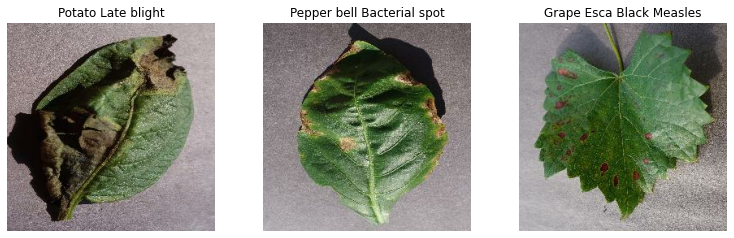

In [24]:
plt.figure(figsize=(13, 13))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(2):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        arr = labels[i].numpy()
        tuple = np.where(arr == 1)
        plt.title(class_names[tuple[0][0]])
        plt.axis("off")

## Modelo creado desde cero

In [25]:
inputs = keras.Input(shape=(size_x, size_y, 3)) 
x = layers.Rescaling(1./255)(inputs) 
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(58, activation="softmax")(x)
model0 = keras.Model(inputs=inputs, outputs=outputs)

model0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856 

## Entrenamiento y guardado de resultados del modelo cero

In [26]:
callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="model0/best_version",
 save_best_only=True,
 monitor="val_loss")
]

In [27]:
model0.compile(loss="categorical_crossentropy",
 optimizer="rmsprop",
 metrics=["accuracy"])

In [28]:
history = model0.fit(
 train_dataset,
 epochs=30,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/30
104/104 [==============================] - 56s 253ms/step - loss: 4.1861 - accuracy: 0.0855 - val_loss: 2.8596 - val_accuracy: 0.2625
INFO:tensorflow:Assets written to: model0\best_version\assets
Epoch 2/30
104/104 [==============================] - 20s 184ms/step - loss: 2.6684 - accuracy: 0.2970 - val_loss: 2.5063 - val_accuracy: 0.3074
INFO:tensorflow:Assets written to: model0\best_version\assets
Epoch 3/30
104/104 [==============================] - 20s 184ms/step - loss: 1.8169 - accuracy: 0.4952 - val_loss: 2.5267 - val_accuracy: 0.3414
Epoch 4/30
104/104 [==============================] - 20s 187ms/step - loss: 1.2683 - accuracy: 0.6320 - val_loss: 1.8251 - val_accuracy: 0.5516
INFO:tensorflow:Assets written to: model0\best_version\assets
Epoch 5/30
104/104 [==============================] - 20s 183ms/step - loss: 0.8393 - accuracy: 0.7525 - val_loss: 1.7428 - val_accuracy: 0.5978
INFO:tensorflow:Assets written to: model0\best_version\assets
Epoch 6/30
104/104 [=======

In [29]:
model0.save('model0/model')

INFO:tensorflow:Assets written to: model0/model\assets


In [31]:
np.save('model0/history.npy',history.history)

## Análisis de resultados

In [32]:
my_model = load_model('model0/model')

In [33]:
my_history=np.load('model0/history.npy',allow_pickle='TRUE').item()

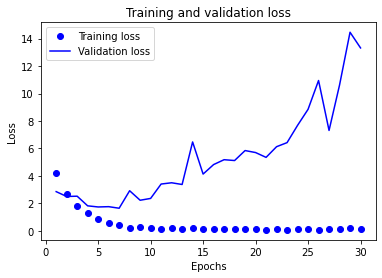

In [34]:
loss = my_history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

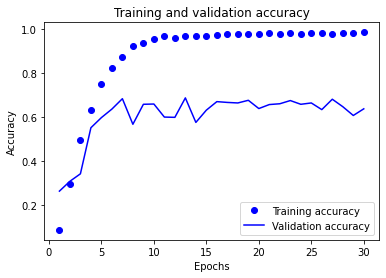

In [35]:
plt.clf()
acc = my_history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [36]:
model = keras.models.load_model('model0/model')
results= model.evaluate(test_dataset)
results

13/13 [==============================] - 4s 238ms/step - loss: 11.7977 - accuracy: 0.6687


[11.797684669494629, 0.6686967015266418]

In [37]:
model = keras.models.load_model('model0/best_version')
results= model.evaluate(test_dataset)
results

13/13 [==============================] - 2s 70ms/step - loss: 1.4548 - accuracy: 0.6784


[1.4547779560089111, 0.6784409284591675]